# LAB | Ensemble Methods

**Load the data**

In this challenge, we will be working with the same Spaceship Titanic data, like the previous Lab. The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

In this Lab, you should try different ensemble methods in order to see if can obtain a better model than before. In order to do a fair comparison, you should perform the same feature scaling, engineering applied in previous Lab.

In [64]:
#Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

#accuracy, percision recall

In [65]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Now perform the same as before:
- Feature Scaling
- Feature Selection


**The shape**

In [66]:
#your code here
spaceship.shape

(8693, 14)

**data types**

In [67]:
spaceship.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


**null values**

In [68]:
spaceship.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

**removal/modification**

In [69]:
spaceship.dropna(inplace=True)

In [70]:
# so only the letters show for the cabin
spaceship['Cabin'] = spaceship['Cabin'].str[0]
spaceship['Cabin'] = spaceship['Cabin'].str.upper()


In [71]:
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [72]:
spaceship.drop(['PassengerId', 'Name'], axis=1, inplace=True)

In [73]:
spaceship.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6606 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    6606 non-null   object 
 1   CryoSleep     6606 non-null   object 
 2   Cabin         6606 non-null   object 
 3   Destination   6606 non-null   object 
 4   Age           6606 non-null   float64
 5   VIP           6606 non-null   object 
 6   RoomService   6606 non-null   float64
 7   FoodCourt     6606 non-null   float64
 8   ShoppingMall  6606 non-null   float64
 9   Spa           6606 non-null   float64
 10  VRDeck        6606 non-null   float64
 11  Transported   6606 non-null   bool   
dtypes: bool(1), float64(6), object(5)
memory usage: 625.8+ KB


**Dummies**

In [74]:
spaceship = pd.get_dummies(spaceship, columns=["HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP"])

In [75]:
spaceship.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6606 entries, 0 to 8692
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        6606 non-null   float64
 1   RoomService                6606 non-null   float64
 2   FoodCourt                  6606 non-null   float64
 3   ShoppingMall               6606 non-null   float64
 4   Spa                        6606 non-null   float64
 5   VRDeck                     6606 non-null   float64
 6   Transported                6606 non-null   bool   
 7   HomePlanet_Earth           6606 non-null   bool   
 8   HomePlanet_Europa          6606 non-null   bool   
 9   HomePlanet_Mars            6606 non-null   bool   
 10  CryoSleep_False            6606 non-null   bool   
 11  CryoSleep_True             6606 non-null   bool   
 12  Cabin_A                    6606 non-null   bool   
 13  Cabin_B                    6606 non-null   bool   
 1

In [76]:
spaceship.columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'CryoSleep_False', 'CryoSleep_True', 'Cabin_A',
       'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
       'Cabin_T', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'VIP_False', 'VIP_True'],
      dtype='object')

**Perform Train Test Split**

In [77]:
#your code here
features = spaceship.drop(columns = ['Transported', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'CryoSleep_False', 'CryoSleep_True', 'Cabin_A',
       'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
       'Cabin_T', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'VIP_False', 'VIP_True'])

target = spaceship['Transported']

In [78]:
x_tr, x_t, y_tr, y_t = train_test_split(features, target, test_size=0.20, random_state=0)


In [79]:
normalizer = MinMaxScaler()

normalizer.fit(x_tr)

MinMaxScaler()

In [80]:
x_tr_norm = normalizer.transform(x_tr)

x_t_norm = normalizer.transform(x_t)

In [81]:
x_tr_norm = pd.DataFrame(x_tr_norm, columns=x_tr.columns)
x_tr_norm.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.405063,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.050633,0.00000,0.000000,0.000000,0.000000,0.000000
2,0.379747,0.00000,0.007916,0.000000,0.051276,0.000000
3,0.215190,0.00131,0.000000,0.046111,0.016378,0.000049
4,0.329114,0.00000,0.000000,0.000000,0.000000,0.000000


In [82]:
x_t_norm = pd.DataFrame(x_t_norm, columns=x_t.columns)
x_t_norm.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.632911,0.0,0.000000,0.0,0.00000,0.0
1,0.227848,0.0,0.000000,0.0,0.00000,0.0
2,0.189873,0.0,0.000000,0.0,0.00000,0.0
3,0.658228,0.0,0.000000,0.0,0.00000,0.0
4,0.784810,0.0,0.054775,0.0,0.07774,0.0


**Model Selection** - now you will try to apply different ensemble methods in order to get a better model

- Bagging and Pasting

In [83]:
#your code here
bagging_reg = BaggingClassifier(DecisionTreeClassifier(max_depth=20),
                               n_estimators=100, max_samples=1000)

In [84]:
bagging_reg.fit(x_tr_norm, y_tr)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                  max_samples=1000, n_estimators=100)

In [85]:
pred = bagging_reg.predict(x_t_norm)

print("Accuracy", accuracy_score(pred, y_t))
print("Recall", recall_score(pred, y_t))
print("Precision", precision_score(y_t, pred, average="binary"))


Accuracy 0.7813918305597579
Recall 0.7569060773480663
Precision 0.7569060773480663


- Random Forests

In [86]:
#your code here
forest = RandomForestClassifier(n_estimators=100,
                               max_depth=20)

In [87]:
forest.fit(x_tr_norm, y_tr)

RandomForestClassifier(max_depth=20)

In [88]:
forest.fit(x_tr_norm, y_tr)

RandomForestClassifier(max_depth=20)

In [89]:
pred = forest.predict(x_t_norm)

print("Accuracy", accuracy_score(pred, y_t))
print("Recall", recall_score(pred, y_t))
print("Precision", precision_score(y_t, pred, average="binary"))


Accuracy 0.7760968229954615
Recall 0.7489768076398363
Precision 0.7489768076398363


- Gradient Boosting

In [90]:
gb_reg = GradientBoostingClassifier(max_depth=20,
                                   n_estimators=100)

In [91]:
gb_reg.fit(x_tr_norm, y_tr)

GradientBoostingClassifier(max_depth=20)

In [99]:
pred = gb_reg.predict(x_t_norm)

print("Accuracy", accuracy_score(pred, y_t))
print("Recall", recall_score(pred, y_t))
print("Precision", precision_score(y_t, pred, average="binary"))

Accuracy 0.7344931921331316
Recall 0.6987179487179487
Precision 0.6987179487179487


- Adaptive Boosting

In [95]:
#your code here
ada_reg = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20),
                            n_estimators=100)

In [96]:
ada_reg.fit(x_tr_norm, y_tr)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                   n_estimators=100)

In [97]:
pred = ada_reg.predict(x_t_norm)

print("Accuracy", accuracy_score(pred, y_t))
print("Recall", recall_score(pred, y_t))
print("Precision", precision_score(y_t, pred, average="binary"))

Accuracy 0.762481089258699
Recall 0.7341430499325237
Precision 0.7341430499325237


Which model is the best and why?

In [98]:
#comment here
# Bagging and Pasting is the best, from looking at the 
# results we see that its the strongest model with a value of 0.7569060773480663

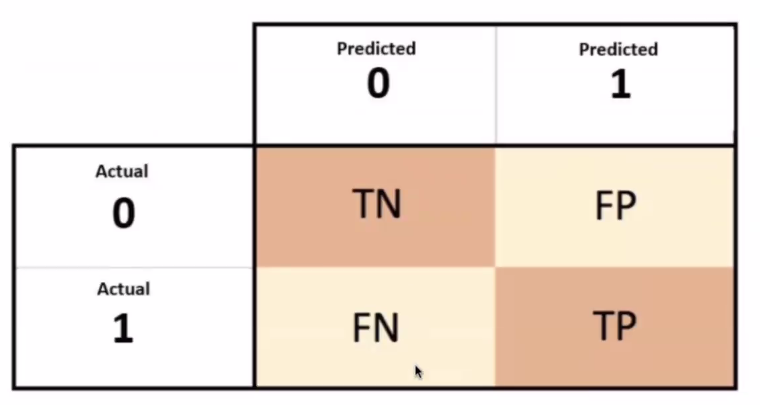